# Group Project - Take Five

### Chathuranga Alwis | Jemin Lee | Phua Sheng-He | Jack Walsh | Ziling Huang

Git Repo: https://eng-git.canterbury.ac.nz/jle147/data201-group-project.git

### Cleaning the the Datasets

In [1]:
library(tidyverse)
library(lubridate)
library(glue)
library(skimr)
library(visdat)
library(ggplot2)
library(stringr)
library(compare)
library(purrr)
library(splitstackshape)
library(knitr)
library(rvest)
library(RSelenium)
library(googleway)
library(readxl)
library(writexl)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse



Attaching package: 'compare'


The following object is masked from 'package:base':

    isTRUE


Loading required package: xml2


Attaching package: 'rvest'


The following object is masked from 'package:purrr':

    pluck


The following object is masked from 'package:readr':

    guess_encoding


Warning message:
"package 'RSelenium' was built under R version 4.0.3"
Warning message:


In [2]:
cas_df <- read_csv('Crash_Analysis_System__CAS__Data.csv')
tf_df <- read_csv('TrafficService.csv')

Parsed with column specification:
cols(
  .default = col_double(),
  crashDirectionDescription = col_character(),
  crashLocation1 = col_character(),
  crashLocation2 = col_character(),
  crashRoadSideRoad = col_logical(),
  crashSeverity = col_character(),
  crashSHDescription = col_character(),
  directionRoleDescription = col_character(),
  flatHill = col_character(),
  holiday = col_character(),
  intersection = col_logical(),
  light = col_character(),
  region = col_character(),
  roadCharacter = col_character(),
  roadLane = col_character(),
  roadSurface = col_character(),
  streetLight = col_character(),
  tlaName = col_character(),
  trafficControl = col_character(),
  urban = col_character(),
  weatherA = col_character()
  # ... with 1 more columns
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  road_name = col_character(),
  start_name = col_character(),
  end_name = col_character(),
  latest = col_chara

In [3]:
#Create a sub df of the original df, because we do not need all of the columns. 
#MORE COLUMNS CAN BE ADDED IF MORE DETAIL IS NEEDED
sub_ts_df <- tf_df %>% 
        select(OBJECTID, road_name, start_name, end_name, adt, count_date, peak_hour, pccar, pclcv, pcheavy)

In [4]:
#Shows the various statistics of each column that is selected and its type
sub_ts_df %>% summary()
#from here we can tell that count_date could be changed into R's date format for better wrangling

    OBJECTID      road_name          start_name          end_name        
 Min.   :    1   Length:10880       Length:10880       Length:10880      
 1st Qu.: 2721   Class :character   Class :character   Class :character  
 Median : 5440   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 5440                                                           
 3rd Qu.: 8160                                                           
 Max.   :10880                                                           
                                                                         
      adt          count_date         peak_hour             pccar       
 Min.   :     0   Length:10880       Length:10880       Min.   :  0.00  
 1st Qu.:   654   Class :character   Class :character   1st Qu.: 87.00  
 Median :  2249   Mode  :character   Mode  :character   Median : 94.00  
 Mean   :  6400                                         Mean   : 91.66  
 3rd Qu.:  8573                            

In [5]:
#an alternative way to see the internal structure of the data, but does not show as much summary()
sub_ts_df %>% str()

tibble [10,880 x 10] (S3: tbl_df/tbl/data.frame)
 $ OBJECTID  : num [1:10880] 1 2 3 4 5 6 7 8 9 10 ...
 $ road_name : chr [1:10880] "BRAMLEY DR" "AWHITU RD" "AWHITU RD" "AWHITU RD" ...
 $ start_name: chr [1:10880] "FIELDING CRES (WEST)" "KING ST (SUMPS RHS)" "WAIPIPI WHARF RD (POWERPOLE LHS)" "CRAIG RD" ...
 $ end_name  : chr [1:10880] "FIELDING CRES (EAST)" "MILLBROOK DR" "CRAIG RD" "GORDON RD" ...
 $ adt       : num [1:10880] 451 3831 613 1380 858 ...
 $ count_date: chr [1:10880] "2002/03/21 00:00:00+00" "2012/03/22 00:00:00+00" "2004/06/11 00:00:00+00" "1990/04/16 00:00:00+00" ...
 $ peak_hour : chr [1:10880] NA "1700" "8:00" NA ...
 $ pccar     : num [1:10880] NA 92 81 81 81 86 92 92 0 92 ...
 $ pclcv     : num [1:10880] NA 4 9 9 9 8 3 4 97 5 ...
 $ pcheavy   : num [1:10880] NA 4 10 10 10 6 5 4 3 3 ...


In [6]:
#deletes rows which has a particular column with NA. Gave it a general function name as it can be used later to clear unwanted rows
#returns a new tibble without the NA rows
clear_rows_NA <- function(df, desiredCols) {
  cleared_df <- complete.cases(df[, desiredCols])
  return(df[cleared_df, ])
}
#With the clearing of the NA values, we are now reduced from 10880 rows to 7301 rows
# count(sub_traffic_df)
sub_ts_df <- clear_rows_NA(sub_ts_df, "peak_hour")
# count(sub_traffic_df)

In [7]:
#change the format of count_date to a Date format
sub_ts_df <- sub_ts_df %>% 
        mutate(count_date = as.Date((substr(count_date, 1, 10)), tryFormats = c("%Y/%m/%d")))
#using the library lubridate, we can extract only the year from count_date 
sub_ts_df <- sub_ts_df %>% 
        mutate(count_year = as.integer(year(count_date)))

In [8]:
#returns a time in a consistent format with the rest of the dataset
convert_proper_time_format <- function(time) {
    #get rid of all whitespaces in each time field
    time <- gsub(" ", "", time, fixed = TRUE)
    if ((nchar(time) == 5) && (str_detect(time, ":") == TRUE)) {
        return (time)
    }
    #if length of time field is 3, means its a time in the format like 800 or 500 which 
    #represents 8am and 5am respectively we want things to be consistent, so we add a 0 
    #in front of each of these types of times
    if (nchar(time) == 3) {
        time <- glue("0{time}")
    } 
    
    #if ":" exists in the time field and the time field is of length 4, means the string
    #does not have the "0" in front of single digit times. thus, same solution as above,
    #add a "0" to the time
    if ((str_detect(time, ":") == TRUE) && (nchar(time) == 4)) {
        time <- glue("0{time}")
    } 
    
    #if ":" does not exist, just add it in the middle of the string as by now, the string
    # would have at least 4 characters in the correct format
    if (str_detect(time, ":") == FALSE) {
        time <- glue("{substr(time, 1, 2)}:{substr(time, 3, 4)}")
    }
    
    #special cases whereby time values are "0:", so we just take it that these times are
    #00:00, instead of getting rid of them
    if (nchar(time) != 5) {
        time <- glue("0{time}00")
    }
    return (time)
}

#ensures the result of each time if of type char. But since we will be getting the average
#of these peak_hours, we will later convert these times into either a numeric or dbl value
modified_peak_hour <- map_chr(sub_ts_df$peak_hour, convert_proper_time_format)
sub_ts_df <- sub_ts_df %>% 
        mutate(peak_hour = modified_peak_hour)

In [9]:
#extract out hour and minute into its own column, so that getting the average of these times 
#would be easier
sub_ts_df <- sub_ts_df %>% 
        mutate(hour = as.integer(substr(peak_hour, 1, 2)), 
               minute = as.integer(substr(peak_hour, 4, 5)))

#bottom are checks to see if the extraction of hour and minute produced any NA values. Also acts
#as a check to see if any other peak_hour value formats still exists after the 
#convert_proper_time_format function 
nrow(sub_ts_df[is.na(sub_ts_df$hour),])
nrow(sub_ts_df[is.na(sub_ts_df$minute),])

#turns out there is one more row which has a value "9:00/" as its peak_hour which was not 
#caught in the function. And since it does not have values for pccar, pclcv ..., it will be 
#deleted from the table because it is not useful.
sub_ts_df <- sub_ts_df %>% 
        filter(peak_hour != "9:00/")

#rearranging the columns in the df to make it neater
sub_ts_df <- sub_ts_df[, c(1, 2, 3, 5, 10, 11, 12, 4, 7, 8, 9)]

sub_ts_df <- sub_ts_df %>% mutate(adt = sapply(adt, as.integer), 
                                            pccar = sapply(pccar, as.integer),
                                            pclcv = sapply(pclcv, as.integer),
                                            pcheavy = sapply(pcheavy, as.integer))

[1] 0

[1] 0

In [10]:
#the bottom code finds the number of rows that has the field "pccar" empty.
#get the average of a
nrow(sub_ts_df[is.na(sub_ts_df$pccar),])

[1] 511

In [11]:
nrow(sub_ts_df) 
# just check the total number of rows
nrow(sub_ts_df[!is.na(sub_ts_df$pccar),])
# and the number of rows which is not NAs

[1] 7301

[1] 6790

In [12]:
# There are many NAs in 'pccar','pclcv','pcheavy'
# Since they are not useful and I could not find a reasonable value to replace, I decide to remove those rows
# new a sub df without NA
sub_ts_df <- sub_ts_df[!is.na(sub_ts_df$pccar),]
nrow(sub_ts_df)

[1] 6790

In [13]:
sub_ts_df %>% sample_n(10)

OBJECTID,road_name,start_name,adt,pcheavy,count_year,hour,end_name,peak_hour,pccar,pclcv
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
3401,CUMBERLAND AVE,GARNET RD,420,3,2012,15,WARNOCK ST,15:00,96,1
2625,KELVIN RD (PAPAKURA),CLEVEDON RD,2675,3,2012,16,WILLIS RD,16:00,96,1
7068,NEW NORTH RD,ASQUITH AVE,23170,3,2016,16,LLOYD AVE (LHS),16:45,96,1
5132,PAH RD (EPSOM),SELWYN RD,22692,5,1986,16,GREENFIELD RD,16:45,85,10
316,MAGIC WAY,RUSHBURY PL,3576,1,2005,8,RIVERTON DR RAB,08:00,98,1
6424,SETTLEMENT RD (PUKEKOHE),TRAMWAY RD,324,9,2005,8,CITY BOUNDARY,08:00,87,4
3897,SNAPPER RD,STILLWATER CRES,192,4,2013,13,DUCK CREEK RD 2,13:15,94,2
8170,BOUNDARY RD (WEST),ISRAEL AVE,10390,1,2017,16,PRESTON RD RAB,16:30,98,1
9864,AWANOHI RD,EAST COAST RD,1070,7,2018,7,ALPURT BRIDGE,07:30,92,1


In [14]:
#renaming of column names
sub_ts_df <- rename(sub_ts_df, 'Road_Name'='road_name',
                                              'Start_Name' = 'start_name', 
                                              'End_Name' = "end_name", 
                                              'Count_Year'='count_year',
                                              'Hour' = 'hour', 
                                              'ADT' = 'adt', 
                                              'Peak_Hour' = 'peak_hour',
                                              'Perc_Cars' = 'pccar',
                                              'Perc_Light_CommVehicles' = 'pclcv',
                                              'Perc_HeavyVehicles' = 'pcheavy')
sub_ts_df <- sub_ts_df %>% select(-Hour)
sub_ts_df %>% sample_n(10)

OBJECTID,Road_Name,Start_Name,ADT,Perc_HeavyVehicles,Count_Year,End_Name,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
5983,MIRRABOOKA AVE,KADINA PL,1821,2,2005,KOOKABURRA PL,08:00,97,1
4251,ASQUITH AVE,FOWLER AVE,4078,5,1988,KNIGHT AVE,07:45,85,10
7246,MILL LANE,QUEEN ST 2,5149,4,2016,WHITTAKER RD,11:15,95,1
587,MAGHERA DR,MELLEFONT CL,2634,1,2005,MACNEAN DR,17:00,98,1
2458,WHITFORD-MARAETAI RD,JACK LACHLAN DR,8321,3,2011,BEACHLANDS RD RAB,17:00,96,1
7167,HILLCREST RD (PAPATOETOE),STATION RD,3950,2,2016,HILL RD,08:00,98,0
3804,CLIFTON RD (TAKAPUNA),LAKE RD,511,2,2013,HAURAKI RD,13:45,97,1
9753,NORTHCOTE RD (SOUTH-SIDE LANE) (EAST),TAHAROTO RD,13370,6,2018,ON RAMP,15:00,93,1
7736,BETHELLS RD (WCC),URBAN/RURAL,2815,5,2017,BRIDGE (1ST ABUTMENT),13:30,94,1


In [15]:
# we also need to check wether the sum of "pccar" "pclcv" and "pcheavy" amounts to 100%
# otherwise the row does not make sense

cols =c('Perc_Cars', 'Perc_Light_CommVehicles', 'Perc_HeavyVehicles')

sub_ts_df <- sub_ts_df %>% 
  filter(rowSums(sub_ts_df[,cols]) == 100)
# filter out if sum of three pc columns is not equal to 100

sub_ts_df %>% sample_n(10)# and now we have cleaner dataframe 

OBJECTID,Road_Name,Start_Name,ADT,Perc_HeavyVehicles,Count_Year,End_Name,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
7549,MUNROS RD,END OF SEAL,12,7,2017,END,08:45,93,0
9966,ODONNELL AVE,PARKINSON AVE,2637,2,2018,RICHARDSON RD,08:15,98,0
9113,OLD LAKE RD,NICCOL AVE,3665,5,2018,WICKLOW RD,14:30,94,1
9851,GREAT SOUTH RD (PAPAKURA),SUBWAY RD,10036,5,2018,OSHANNESSEY ST,16:45,93,2
1704,CORLETT RD,WHAREHINE RD,39,10,2010,GATE,11:00,81,9
2715,WYMONDLEY RD,LARSEN ST,2905,2,2012,LAXON AVE (LHS),08:00,98,0
4003,HARRISON ST (WELLSFORD),RODNEY ST (S HWAY 1),243,8,2013,END OF SEAL,10:15,92,0
3966,MATAKANA RD,START OF LHS KCC,7702,4,2013,70KM/H SIGN,10:45,94,2
3483,FERNHILL WAY,MEDALLION DR,213,2,2013,MAY POTTER CLOSE,17:00,98,0


In [16]:
#Deletes rows which has a particular column with NA. Gave it a general function name as it can be used later to clear unwanted rows
#Returns a new tibble without the NA rows
clear_rows_NA <- function(df, desiredCols) {
  cleared_df <- complete.cases(df[, desiredCols])
  return(df[cleared_df, ])
}

#Clearing of the NA values
sub_ts_df <- clear_rows_NA(sub_ts_df, "ADT")

In [17]:
#remove all strings in parentheses
sub_ts_df$Road_Name <- str_replace(sub_ts_df$Road_Name, " \\(.*\\)", "")
sub_ts_df$Start_Name <- str_replace(sub_ts_df$Start_Name, " \\(.*\\)", "")
sub_ts_df$End_Name <- str_replace(sub_ts_df$End_Name, " \\(.*\\)", "")

sub_ts_df %>% sample_n(10)

OBJECTID,Road_Name,Start_Name,ADT,Perc_HeavyVehicles,Count_Year,End_Name,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
8282,HOPETOUN ST,ST JAMES ST,11999,3,2018,PITT ST,08:00,97,0
7153,BOTANY RD,UNION RD RAB,15940,5,2016,PAKURANGA RD,17:15,94,1
2826,MINARET DR,MALVINA PL,825,1,2013,CHERRY RD,08:00,99,0
3799,HARLEY RD,LAKE RD,593,2,2015,START OF SPLIT,07:30,98,0
10332,KAHIKATEA FLAT RD,DAIRY FLAT HIGHWAY,3904,11,2018,URBAN/RURAL,16:00,87,2
2614,SHEEHAN AVE,DOMINION RD,1876,5,2012,EASTBURN ST,07:45,95,0
2632,GREAT SOUTH RD,BRYNBELA CRT,21300,5,2014,DON ST,15:15,94,1
2759,SHIRLEY RD,CORONATION RD RAB,8383,3,2013,JENNIFER PL,07:45,97,0
10694,TRIG HILL RD,END OF SEAL,397,11,2018,END,15:30,88,1


In [18]:
# list of abbreviations and their full texts
dict <- list(ST = "STREET", RD = "ROAD", LD = "LANE", PL = "PLACE", DR = "DRIVE", CRES = "CRESCENT", AVE = "AVENUE")

In [19]:
# go through road_name, start_name, and end_name columns to change the abbreviation to full text

for(i in 1:length(dict)){
  sub_ts_df$Road_Name <- gsub(paste0("\\b", names(dict)[i], "\\b"), dict[[i]], sub_ts_df$Road_Name)
}

for(i in 1:length(dict)){
  sub_ts_df$Start_Name <- gsub(paste0("\\b", names(dict)[i], "\\b"), dict[[i]], sub_ts_df$Start_Name)
}

for(i in 1:length(dict)){
  sub_ts_df$End_Name <- gsub(paste0("\\b", names(dict)[i], "\\b"), dict[[i]], sub_ts_df$End_Name)
}

sub_ts_df %>% sample_n(10)

OBJECTID,Road_Name,Start_Name,ADT,Perc_HeavyVehicles,Count_Year,End_Name,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>
10557,WIRI STATION ROAD,HOBILL AVENUE,7073,22,2018,DRUCES ROAD,16:15,76,2
3694,MOZELEY AVENUE,LAKE ROAD,2172,1,2013,VICTORIA ROAD,15:15,98,1
6938,BICKNELL ROAD,ABIRU CRESCENT,2121,2,2016,ABIRU CRESCENT,15:00,98,0
4138,WILLIAMSON AVENUE,LAKE ROAD,1831,6,2015,SEACLIFFE AVENUE,11:15,94,0
9241,RICHARDSON ROAD,OWAIRAKA AVENUE,9912,4,2018,HENDON AVENUE,08:00,96,0
7043,PIHA ROAD,TE AHUAHU ROAD,2424,2,2016,PENDRELL ROAD,12:30,97,1
7961,MOUMOUKAI ROAD,OTAU VALLEY ROAD,100,4,2017,END OF SEAL,13:15,93,3
10132,WALLACE ROAD,STREET GEORGE STREET,5066,4,2018,FAIRVIEW ROAD,15:00,96,0
9944,WELLESLEY STREET WEST,QUEEN STREET,7350,13,2018,ELLIOT STREET,17:15,87,0


In [20]:
#Extracting the needed columns from the Crash Dataset
sub_cas_df <- cas_df %>% select(Crash_Location1=crashLocation1, 
                                Crash_Location2=crashLocation2, 
                                Crash_Year=crashYear, 
                                Region=region, 
                                OBJECTID,
                                Speed_Limit = speedLimit,
                                Road_Surface = roadSurface,
                                Road_Lane = roadLane,
                                Flat_Or_Hill = flatHill)
sub_cas_df %>% sample_n(10)

Crash_Location1,Crash_Location2,Crash_Year,Region,OBJECTID,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
WINGATE CRESCENT,CAMBRIDGE TERRACE,2013,Wellington Region,422814,50,Sealed,2-way,Flat
WAIMAIRI ROAD,MAIDSTONE ROAD,2004,Canterbury Region,410917,50,Sealed,2-way,Flat
HOBSON ST,VICTORIA ST WEST,2010,Auckland Region,250150,50,Sealed,2-way,Flat
POWNALL ST,TARARUA ST,2010,Wellington Region,254440,50,Sealed,2-way,Flat
ORMOND ROAD,FITZHERBERT STREET,2019,Gisborne Region,104761,50,Sealed,2-way,Flat
MCKENZIE ST,HOKIO BEACH ROAD,2013,Manawatu-Wanganui Region,27457,50,Sealed,2-way,Flat
GREAT SOUTH ROAD,CAMPBELL ROAD,2008,Auckland Region,527738,50,Sealed,2-way,Flat
PARK AVENUE,LENDENFELD DRIVE,2009,Auckland Region,308850,50,Sealed,2-way,Flat
CUBA ST,JACKSON ST,2008,Wellington Region,1175,50,Sealed,2-way,Flat


In [21]:
#another way to look at the dataset, alternative to summary()
sub_cas_df %>% skim()
#all of the data types here seem to be what we require for our wrangling

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             730280    
Number of columns          9         
_______________________              
Column type frequency:               
  character                6         
  numeric                  3         
________________________             
Group variables            None      

-- Variable type: character ----------------------------------------------------
# A tibble: 6 x 8
  skim_variable   n_missing complete_rate   min   max empty n_unique whitespace
* <chr>               <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Crash_Location1         0         1         1    98     0    35140          0
2 Crash_Location2       550         0.999     3    70     0    48523          0
3 Region                 94         1.00     12    24     0       16          0
4 Road_Surface            0         1         4    11     0        4          0

In [22]:
for(i in 1:length(dict)){
  sub_cas_df$Crash_Location1 <- gsub(paste0("\\b", names(dict)[i], "\\b"), dict[[i]], sub_cas_df$Crash_Location1)
}

for(i in 1:length(dict)){
  sub_cas_df$Crash_Location2 <- gsub(paste0("\\b", names(dict)[i], "\\b"), dict[[i]], sub_cas_df$Crash_Location2)
}

In [23]:
#Getting only the values Needed 
sub_cas_df <- filter(sub_cas_df, Crash_Year >= 1971 & Crash_Year <= 2019)

In [24]:
sub_cas_df %>% sample_n(10)

Crash_Location1,Crash_Location2,Crash_Year,Region,OBJECTID,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
COURTNEY ROAD,LANDVIEW ROAD,2015,Bay of Plenty Region,343802,50,Sealed,2-way,Hill Road
GEORGE BOLT MEMORIAL DRIV,JOHN GOULTER DRIVE,2015,Auckland Region,637519,60,Sealed,2-way,Flat
MOORES VALLEY ROAD,MAIN ROAD,2004,Wellington Region,670125,50,Sealed,2-way,Flat
TAITA DRIVE,FAIRWAY DRIVE,2001,Wellington Region,23099,50,Sealed,2-way,Flat
BRODIE STREET,CORFE STREET,2012,Canterbury Region,179609,50,Sealed,2-way,Flat
WEYMOUTH ROAD,RUSSELL ROAD,2008,Auckland Region,168762,50,Sealed,2-way,Flat
POINT ENGLAND ROAD,LINE ROAD,2008,Auckland Region,434508,50,Sealed,2-way,Flat
SH 1N,SHAWCROFT ROAD,2004,Manawatu-Wanganui Region,470323,100,Sealed,2-way,Flat
TE WHAREPU ROAD,TE KAUWHATA ROAD,2012,Waikato Region,24772,100,Sealed,1-way,Flat


### Combining the two Datasets, using the keys: Crash_Location1 & Crash_Location2

In [25]:
#find out how many rows of data before combining the two datasets
sub_cas_df %>% nrow()

[1] 722278

#### Our original idea was to merge the two datasets using Lists. 

The below are some of the functions and code snippets of our attempt in trying to combine them.

In [26]:
#sub_ts_road_name_combined_df <- sub_ts_df %>% unite(location, sep=", ", road_name:end_name, remove=FALSE, na.rm = TRUE)
#sub_ts_road_name_combined_df <- concat.split(sub_ts_road_name_combined_df, 2, sep = ",", structure = "list")

#sub_cas_locations_combined_df <- sub_cas_df %>% unite(location, sep=", ", crashLocation1:crashLocation2, remove=FALSE, na.rm = TRUE)
#sub_cas_locations_combined_df <- concat.split(sub_cas_locations_combined_df, 1, sep = ",", structure = "list")

In [27]:
location_match <- function(crash_location, traffic_location) {
    
    crash_location_len = length(crash_location)
    match_vector = vector(mode = "logical", length = crash_location_len)
    print(crash_location_len)
    for (i in 1:crash_location_len) {
        match_vector[i] = crash_location[i] %in% traffic_location
        if(length(which(crash_location[i] %in% traffic_location)) != 0){
            traffic_location = traffic_location[-match(crash_location[i], traffic_location)]
        }
    }
    #result = all(match_vector)
    
    return(match_vector)
}

In [28]:
combine_location <- function(crash_location, traffic_location)
{
    #This function uses Set Intersect to connect the two columns
    len = length(traffic_location)
    if(setequal(intersect(crash_location, traffic_location), crash_location) == TRUE)
    {
        result <- tibble(CLocation = crash_location)
    }
    else
    {
        result <- NULL
    }
    return(result)
}

In [29]:
do_for_all_crash <- function(crash_location_col, traffic_location_col)
{
    len_crash <- length(crash_location_col)
    result = c()
    i = 1
    while(i <= len_crash)
    {
        result[[i]] = combine_location(crash_location_col[[i]][[1]], traffic_location_col)
        i = i + 1
    }
    all_common = result
    return(all_common)
}

However as we later realised that this was quite complicated and did not work, we thought of using the following method.


#### Here we are merging the two datasets using INNER_JOIN and UNION, as it is far easier and straghtforward. 

However, in order to use UNION we had to make the two datasets UNION COMPATIBLE.

In [30]:
#Trying out all possibilites of combining the two datasets (3 * 2 = 6)
# ====================================================================================================================

x<-inner_join(sub_cas_df, sub_ts_df, by = 
           c("Crash_Location1" = "Road_Name", "Crash_Location2" = "End_Name"))

y<-inner_join(sub_cas_df, sub_ts_df, by = 
           c("Crash_Location1" = "Road_Name", "Crash_Location2" = "Start_Name"))

#Combining the above two tibbles but making them union compatible
w <- x %>% select(-Start_Name)
q <- y %>% select(-End_Name)

combined <- union(w, q)
combined <- combined %>% distinct(OBJECTID.x, .keep_all = TRUE) 

#----------------------------------------------------------------------------------------------------------------------

x<-inner_join(sub_cas_df, sub_ts_df, by = 
           c("Crash_Location1" = "Start_Name", "Crash_Location2" = "Road_Name"))

y<-inner_join(sub_cas_df, sub_ts_df, by = 
           c("Crash_Location1" = "Start_Name", "Crash_Location2" = "End_Name"))

#Combining the above two tibbles but making them union compatible
w <- x %>% select(-End_Name)
q <- y %>% select(-Road_Name)

combined1 <- union(w, q)
combined <- union(combined, combined1)
combined <- combined %>% distinct(OBJECTID.x, .keep_all = TRUE) 

#----------------------------------------------------------------------------------------------------------------------

x<-inner_join(sub_cas_df, sub_ts_df, by = 
           c("Crash_Location1" = "End_Name", "Crash_Location2" = "Start_Name"))

y<-inner_join(sub_cas_df, sub_ts_df, by = 
           c("Crash_Location1" = "End_Name", "Crash_Location2" = "Road_Name"))

#Combining the above two tibbles but making them union compatible
w <- x %>% select(-Road_Name)
q <- y %>% select(-Start_Name)

combined1 <- union(w, q)
combined <- union(combined, combined1)
Merged_to_Crash <- combined %>% distinct(OBJECTID.x, .keep_all = TRUE) 

#=====================================================================================================================
Merged_to_Crash %>% sample_n(10)

Crash_Location1,Crash_Location2,Crash_Year,Region,OBJECTID.x,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill,OBJECTID.y,ADT,Perc_HeavyVehicles,Count_Year,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>
KILKENNY DRIVE,CHAPEL ROAD,2005,Auckland Region,574790,50,Sealed,2-way,Flat,329,5063,3,2006,08:00,96,1
GREAT SOUTH ROAD,LAURESTON AVENUE,2007,Auckland Region,331247,50,Sealed,2-way,Flat,9521,17619,5,2018,16:30,94,1
SETTLEMENT ROAD,GREAT SOUTH ROAD,2001,Auckland Region,237854,50,Sealed,2-way,Flat,10311,14776,17,2018,16:30,82,1
RICHARDSON ROAD,WHITE SWAN ROAD,2008,Auckland Region,26323,50,Sealed,2-way,Flat,8100,12734,2,2017,17:30,98,0
BEACH ROAD,RONAYNE STREET,2000,Auckland Region,158454,50,Sealed,2-way,Flat,6593,1547,3,2016,17:00,97,0
GREEN LANE WEST,MANUKAU ROAD,2019,Auckland Region,5535,50,Sealed,2-way,Flat,10395,21843,7,2018,16:15,91,2
MATAKANA ROAD,SHARP ROAD,2004,Auckland Region,247992,100,Sealed,2-way,Flat,1099,5987,12,2011,16:00,78,10
HILLSBOROUGH ROAD,QUONA AVENUE,2008,Auckland Region,695656,50,Sealed,2-way,Hill Road,9961,17799,5,2018,16:45,95,0
GREAT NORTH ROAD,ARIKI STREET,2008,Auckland Region,35949,50,Sealed,2-way,Flat,7643,1799,1,2017,08:00,99,0


In [31]:
#After the merge, we took away about 600000 rows.
Merged_to_Crash %>% nrow()

[1] 113816

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             113816    
Number of columns          16        
_______________________              
Column type frequency:               
  character                7         
  numeric                  9         
________________________             
Group variables            None      

-- Variable type: character ----------------------------------------------------
# A tibble: 7 x 8
  skim_variable   n_missing complete_rate   min   max empty n_unique whitespace
* <chr>               <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Crash_Location1         0          1        5    35     0     3771          0
2 Crash_Location2         0          1        5    29     0     4777          0
3 Region                  1          1.00    12    24     0       12          0
4 Road_Surface            0          1        4    11     0        4          0

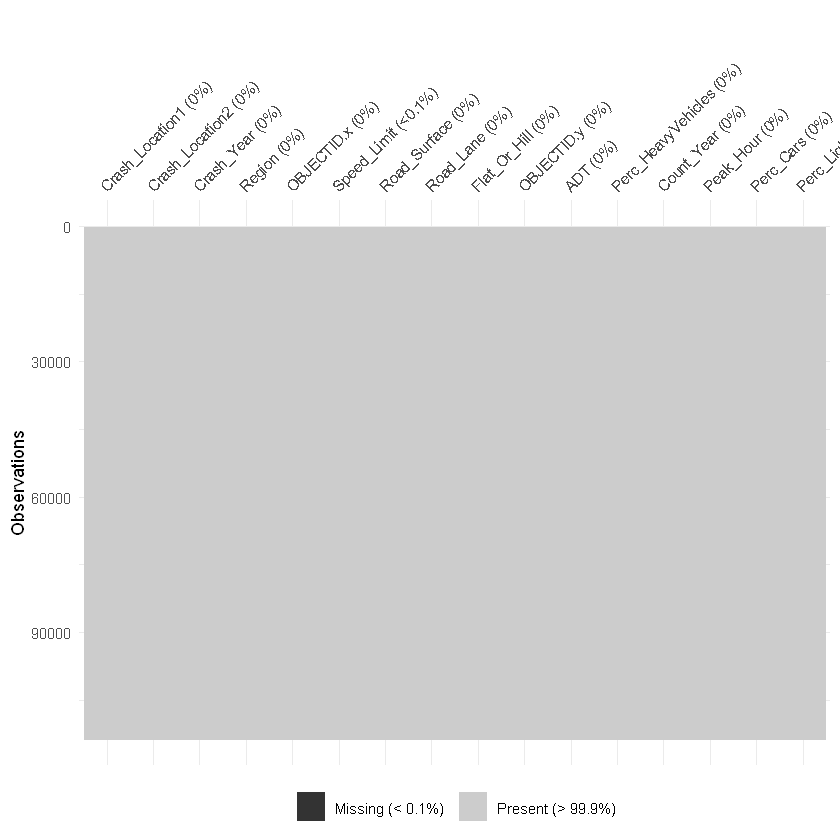

In [32]:
#one final look at our final dataset
Merged_to_Crash %>% skim()

library(visdat)
Merged_to_Crash %>% vis_miss(warn_large_data = FALSE)

#From the dataset we can see that there is one row where region has a missing value and 
#65 rows where the Speed Limit has missing values.

In [33]:
#this is that row where the Region is missing
Merged_to_Crash[is.na(Merged_to_Crash$Region),]

Crash_Location1,Crash_Location2,Crash_Year,Region,OBJECTID.x,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill,OBJECTID.y,ADT,Perc_HeavyVehicles,Count_Year,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>
BLOCKHOUSE BAY ROAD,NEW NORTH ROAD,2019,NA,598309,50,Sealed,2-way,Null,3423,23694,5,2015,11:45,94,1


#### Attempt to use R Selenium to wait on the Google result page to extract the Region of the above two roads.

In [34]:
# binman::rm_platform("phantomjs")
# wdman::selenium(retcommand = TRUE)
# driver <- RSelenium::rsDriver(browser = "chrome",
#                               port = 4837L,
#                               chromever =
#                                 system2(command = "wmic",
#                                         args = 'datafile where name="C:\\\\Program Files (x86)\\\\Google\\\\Chrome\\\\Application\\\\chrome.exe" get Version /value',
#                                         stdout = TRUE,
#                                         stderr = TRUE) %>%
#                                 stringr::str_extract(pattern = "(?<=Version=)\\d+\\.\\d+\\.\\d+\\.") %>%
#                                 magrittr::extract(!is.na(.)) %>%
#                                 stringr::str_replace_all(pattern = "\\.",
#                                                          replacement = "\\\\.") %>%
#                                 paste0("^",  .) %>%
#                                 stringr::str_subset(string =
#                                                       binman::list_versions(appname = "chromedriver") %>%
#                                                       dplyr::last()) %>%
#                                 as.numeric_version() %>%
#                                 max() %>%
#                                 as.character())
# remote_driver <- driver[["client"]] 

#this is the function that would use the R selenium capabilities to extract the region
# get_specific_region <- function(road_name, remote_driver) {
#     url_road_location <- (glue("https://www.google.com/search?q={road_name}"))
#     remote_driver$navigate(url_road_location)
#     remote_driver$setImplicitWaitTimeout(milliseconds =3000)
#     address_element <- remote_driver$findElement(using = 'class', value = 'desktop-title-subcontent')
#     region <- address_element %>%
#                 html_text()
#     return (address_element)
# }
# get_specific_region("BLOCKHOUSE+BAY+ROAD", remote_driver)

In [35]:
#attempt to use the google api to get results but they required an API key
# google_places(search_string = "BLOCKHOUSE BAY ROAD")

In [36]:
# the simple way to solve the NA column is to use the unaltered CAS dataset and sift through all crash location which has the same name and get the region.
# The description is as follows:
#we know for sure each road would be generalised to one region from the dataset. However, a road name can appear in other regions too.
#As such, we will get the counts of a region appearing in the filtered dataset by the target road_names, and get the most commonly appearing
#region and set the NA value region as that.

#returns a string region from two input road names and the given dataset
get_specific_region <- function(road_name1, road_name2, cas_df) {
    #since each road name can appear in crashLocation1 and crashLocation2, and vice versa, we have to get all four combination tallies to get
    #the most commonly appeared region for that road
    unique_regions_count1 <- cas_df %>% filter(crashLocation1 == road_name1) %>% select(region) %>% group_by(region) %>% summarize(count=n())
    unique_regions_count2 <- cas_df %>% filter(crashLocation2 == road_name2) %>% select(region) %>% group_by(region) %>% summarize(count=n())
    unique_regions_count3 <- cas_df %>% filter(crashLocation1 == road_name2) %>% select(region) %>% group_by(region) %>% summarize(count=n())
    unique_regions_count4 <- cas_df %>% filter(crashLocation2 == road_name1) %>% select(region) %>% group_by(region) %>% summarize(count=n())
    
    #combine all the results, and get the summed result of all the possible combinations. 
    merged_result <- bind_rows(unique_regions_count1, unique_regions_count2, unique_regions_count3, unique_regions_count4) %>%
                        group_by(region) %>%
                        summarise_all(funs(sum(., na.rm = TRUE))) 
    
    #the highest appearing row is the region that will replace the NA value
    region_row <- merged_result[which.max(merged_result$count), ]
    return (region_row$region)
}
#replace the NA value with the majority region function above
Merged_to_Crash$Region[is.na(Merged_to_Crash$Region)] <- get_specific_region(Merged_to_Crash$Crash_Location1, Merged_to_Crash$Crash_Location2, cas_df)

Warning message in crashLocation1 == road_name1:
"longer object length is not a multiple of shorter object length"
`summarise()` ungrouping output (override with `.groups` argument)

Warning message in crashLocation2 == road_name2:
"longer object length is not a multiple of shorter object length"
`summarise()` ungrouping output (override with `.groups` argument)

Warning message in crashLocation1 == road_name2:
"longer object length is not a multiple of shorter object length"
`summarise()` ungrouping output (override with `.groups` argument)

Warning message in crashLocation2 == road_name1:
"longer object length is not a multiple of shorter object length"
`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ 

In [37]:
#Check if there is anymore NA values
Merged_to_Crash[is.na(Merged_to_Crash$Region),]

Crash_Location1,Crash_Location2,Crash_Year,Region,OBJECTID.x,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill,OBJECTID.y,ADT,Perc_HeavyVehicles,Count_Year,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>


In [38]:
#check if that NA value is correctly replaced
Merged_to_Crash %>% filter(OBJECTID.x == 598309)

Crash_Location1,Crash_Location2,Crash_Year,Region,OBJECTID.x,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill,OBJECTID.y,ADT,Perc_HeavyVehicles,Count_Year,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>
BLOCKHOUSE BAY ROAD,NEW NORTH ROAD,2019,Auckland Region,598309,50,Sealed,2-way,Null,3423,23694,5,2015,11:45,94,1


As we do not really need the above Merged_to_Crash dataset for our main purpose, we will not try to handle the other missing values or to do further cleaning on it.

### Combining the two Datasets, using Road_Name, Start_Name & End_Name as Keys 

In [39]:
# ====================================================================================================================

x<-inner_join(sub_ts_df, sub_cas_df, by = 
           c("Road_Name" = "Crash_Location1", "End_Name" = "Crash_Location2"))

y<-inner_join(sub_ts_df, sub_cas_df, by = 
           c("Road_Name" = "Crash_Location1", "Start_Name" = "Crash_Location2"))

#Combining the above two tibbles but making them union compatible
combined <- union(x, y)
combined <- combined %>% distinct(OBJECTID.x, .keep_all = TRUE) 

#=====================================================================================================================

x<-inner_join(sub_ts_df, sub_cas_df, by = 
           c("Road_Name" = "Crash_Location2", "End_Name" = "Crash_Location1"))

y<-inner_join(sub_ts_df, sub_cas_df, by = 
           c("Road_Name" = "Crash_Location2", "Start_Name" = "Crash_Location1"))

#Combining the above two tibbles but making them union compatible
combined <- union(x, y)
Merged_to_Traffic <- combined

#=====================================================================================================================
Merged_to_Traffic %>% sample_n(10)

OBJECTID.x,Road_Name,Start_Name,ADT,Perc_HeavyVehicles,Count_Year,End_Name,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles,Crash_Year,Region,OBJECTID.y,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
550,RANFURLY ROAD,FREYBERG AVENUE,2031,2,2009,PUHINUI ROAD,17:00,97,1,2016,Auckland Region,318677,50,Sealed,2-way,Flat
10044,BRUCE MCLAREN ROAD,APPLEWOOD DRIVE,5940,4,2018,LEGACY DRIVE,17:00,96,0,2001,Auckland Region,33816,50,Sealed,2-way,Flat
6963,DARBY STREET,QUEEN STREET,384,5,2016,ELLIOT STREET,08:15,95,0,2000,Auckland Region,677609,50,Sealed,2-way,Flat
9372,PORTSMOUTH ROAD,BOMBAY ROAD,491,9,2018,BARBER ROAD,07:45,88,3,2015,Auckland Region,183355,100,Sealed,2-way,Flat
3188,FARRELLY AVENUE,POTTER AVENUE,1178,1,2014,CHRISTINI STREET,13:45,99,0,2005,Auckland Region,467415,50,Sealed,2-way,Flat
9522,GREAT SOUTH ROAD,CENTRAL AVENUE,20272,3,2018,WATSON PLACE,16:15,96,1,2005,Auckland Region,704065,50,Sealed,2-way,Flat
2803,OTHELLO DRIVE,ZELDA AVENUE,3987,1,2013,DAWSON ROAD,17:15,99,0,2014,Auckland Region,123932,50,Sealed,2-way,Flat
3151,MCLEAN STREET,NEW NORTH ROAD,1265,3,2013,ALLENDALE ROAD,08:00,97,0,2001,Auckland Region,521896,50,Sealed,2-way,Flat
171,PUHINUI ROAD,GREAT SOUTH ROAD,1131,1,2011,EDORVALE AVENUE,14:00,98,1,2015,Auckland Region,705981,50,Sealed,2-way,Flat


[1] 73106

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             73106     
Number of columns          17        
_______________________              
Column type frequency:               
  character                8         
  numeric                  9         
________________________             
Group variables            None      

-- Variable type: character ----------------------------------------------------
# A tibble: 8 x 8
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
* <chr>             <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Road_Name             0          1        7    25     0     2538          0
2 Start_Name            0          1        5    43     0     2810          0
3 End_Name              7          1.00     3    42     0     3340          0
4 Peak_Hour             0          1        5     5     0       62          0
5 Region   

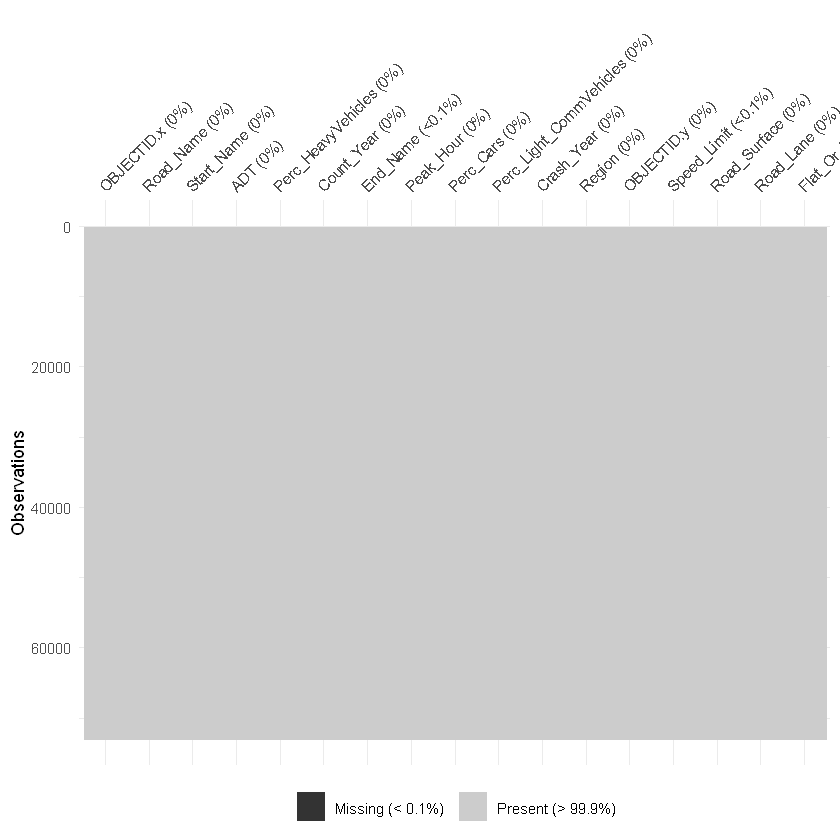

In [40]:
Merged_to_Traffic %>% nrow()
Merged_to_Traffic %>% skim()

library(visdat)
Merged_to_Traffic %>% vis_miss(warn_large_data = FALSE)
#From the output below, we can see that there exists some missing values in the final merged dataset

The above outputs show that there exists some missing values in some rows.


However, as the TrafficService.csv does not contain a column 'Region', we cannot use the previous method here to handle the missing Region value. 

Furthermore, for the rest of the missing values there isn't a possible way to substitute an accurate value with our available data.
Therefore, we decided to Omit all rows containing NA values as that's the only feasible solution we have due to reasons such as Time, Not having the right alternate dataset and work load.

Thus, the new Merged_To_Traffic will have complete data after omiting all NA values.

[1] 73047

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             73047     
Number of columns          17        
_______________________              
Column type frequency:               
  character                8         
  numeric                  9         
________________________             
Group variables            None      

-- Variable type: character ----------------------------------------------------
# A tibble: 8 x 8
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
* <chr>             <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Road_Name             0             1     7    25     0     2538          0
2 Start_Name            0             1     5    43     0     2809          0
3 End_Name              0             1     3    42     0     3339          0
4 Peak_Hour             0             1     5     5     0       62          0
5 Region   

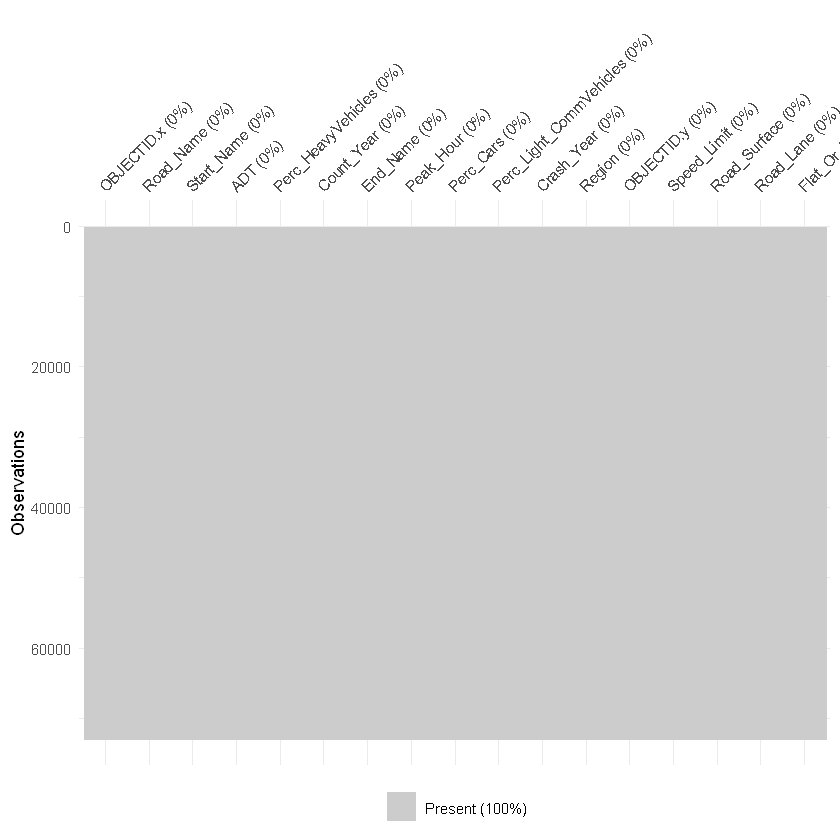

In [41]:
Merged_to_Traffic <- Merged_to_Traffic %>% na.omit()
Merged_to_Traffic %>% nrow()
Merged_to_Traffic %>% skim()
Merged_to_Traffic %>% vis_miss(warn_large_data = FALSE)

In [42]:
Merged_to_Traffic
#This can now be used for any further processing/decision-making.

OBJECTID.x,Road_Name,Start_Name,ADT,Perc_HeavyVehicles,Count_Year,End_Name,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles,Crash_Year,Region,OBJECTID.y,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
9,COOPER ROAD,AWHITU ROAD,37,3,2004,TE TORO ROAD,07:00,0,97,2016,Auckland Region,486111,100,Sealed,2-way,Hill Road
9,COOPER ROAD,AWHITU ROAD,37,3,2004,TE TORO ROAD,07:00,0,97,2006,Auckland Region,517806,100,Sealed,2-way,Flat
9,COOPER ROAD,AWHITU ROAD,37,3,2004,TE TORO ROAD,07:00,0,97,2018,Auckland Region,727081,80,Sealed,2-way,Hill Road
16,KEMP ROAD,AWHITU ROAD,173,6,2008,AWHITU CENTRAL ROAD,14:00,92,2,2002,Auckland Region,257283,100,Sealed,2-way,Flat
16,KEMP ROAD,AWHITU ROAD,173,6,2008,AWHITU CENTRAL ROAD,14:00,92,2,2016,Auckland Region,710904,100,Sealed,2-way,Hill Road
18,KOHEKOHE-KARIOITAHI ROAD,TAURANGARURU ROAD,97,15,2009,KARIOITAHI ROAD,11:00,82,3,2011,Auckland Region,8851,100,Sealed,2-way,Hill Road
18,KOHEKOHE-KARIOITAHI ROAD,TAURANGARURU ROAD,97,15,2009,KARIOITAHI ROAD,11:00,82,3,2010,Waikato Region,12697,100,Sealed,2-way,Hill Road
18,KOHEKOHE-KARIOITAHI ROAD,TAURANGARURU ROAD,97,15,2009,KARIOITAHI ROAD,11:00,82,3,2005,Waikato Region,14212,100,Sealed,2-way,Hill Road
18,KOHEKOHE-KARIOITAHI ROAD,TAURANGARURU ROAD,97,15,2009,KARIOITAHI ROAD,11:00,82,3,2013,Waikato Region,26610,100,Sealed,2-way,Flat


---

## Importing another dataset to get the Region wise Road Condition Index, Pavement Integrity Index and Smooth Travel Exposure

###  Road Condition Index : A measure of the condition of the seal of a sealed road

The Condition Index (CI) is a single index summarising surface condition based on visually measured condition defects (from RAMM rating)	

###  Pavement Integrity Index : A measure of the condition of the pavement and seal of a sealed road

The Pavement Integrity Index (PII) is a combined index of the pavement faults in sealed road surfaces. It is a ‘weighted sum’ of the pavement defects divided by total lane length. PII combines surface faults (CI) with rutting and shoving. 100 - PII ensures that the higher the number the greater the pavement integrity. Pavement integrity index (PII) and the routine for calculating it using the RAMM software, was introduced in the 2003/04 year.	


### Smooth Travel Exposure : A measure of the ride quality of a 'network' of sealed road

Smooth Travel Exposure (STE%) measures the proportion (%) of vehicle kilometres travelled in a year (VKT) that occurs on ‘smooth’ sealed roads and indicates the ride quality experienced by motorists.	

In [43]:
#Reading Each Sheet Data from the RoadCondition.xlsx file
pii_df <- read_excel("RoadCondition.xlsx", sheet = 2)
ci_df <- read_excel("RoadCondition.xlsx", sheet = 3)
ste_df <- read_excel("RoadCondition.xlsx", sheet = 4)

In [44]:
pii_df <- pii_df %>% filter(Hierarchy == 'Region' & pii_df$"U/R/All" == "All Roads") %>% select('NZ/Regin/TA', Pavement_Integrity_Index = '2019/20')
ci_df <- ci_df %>% filter(Hierarchy == 'Region' & ci_df$"U/R/All" == "All Roads") %>% select('NZ/Regin/TA', Road_Condition_Index = '2019/20')
ste_df <- ste_df %>% filter(Hierarchy == 'Region' & ste_df$"U/R/All" == "All Roads") %>% select('NZ/Regin/TA', Smooth_Travel_Exporsure = '2019/20')

In [45]:
#Adding 'Region' to the end of each Region in the following Datasets
for(i in 1:length(pii_df$'NZ/Regin/TA'))
{
  pii_df$'NZ/Regin/TA'[i] <- paste0(pii_df$'NZ/Regin/TA'[i], ' Region')
}

for(i in 1:length(ci_df$'NZ/Regin/TA'))
{
  ci_df$'NZ/Regin/TA'[i] <- paste0(ci_df$'NZ/Regin/TA'[i], ' Region')
}

for(i in 1:length(ste_df$'NZ/Regin/TA'))
{
  ste_df$'NZ/Regin/TA'[i] <- paste0(ste_df$'NZ/Regin/TA'[i], ' Region')
}

In [46]:
#Correcting the Spelling of 'Manawatu-Whanganui Region' as it is needed for the joining part
#Please Note: The correct spelling was retrieved from the below website
#https://www.newzealandnow.govt.nz/regions-nz/whanganui-manawatu

pii_df <- pii_df %>% mutate('NZ/Regin/TA'=recode(pii_df$'NZ/Regin/TA','Manawatu-Wanganui Region'='Manawatu-Whanganui Region'))
ci_df <- ci_df %>% mutate('NZ/Regin/TA'=recode(ci_df$'NZ/Regin/TA','Manawatu-Wanganui Region'='Manawatu-Whanganui Region'))
ste_df <- ste_df %>% mutate('NZ/Regin/TA'=recode(ste_df$'NZ/Regin/TA','Manawatu-Wanganui Region'='Manawatu-Whanganui Region'))

In [47]:
pii_df %>% skim()
ci_df %>% skim()
ste_df %>% skim()
#As it is seen below these does not need to be cleaned.
#Therefore, we will go ahead and combine them onto our Merged_to_Traffic dataset by Region.

#However, this will lead to Data Redundancy, 
#but as it is only a couple rows this has no major effect on the performance/storage

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             14        
Number of columns          2         
_______________________              
Column type frequency:               
  character                1         
  numeric                  1         
________________________             
Group variables            None      

-- Variable type: character ----------------------------------------------------
# A tibble: 1 x 8
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
* <chr>             <int>         <dbl> <int> <int> <int>    <int>      <int>
1 NZ/Regin/TA           0             1    12    32     0       14          0

-- Variable type: numeric ------------------------------------------------------
# A tibble: 1 x 11
  skim_variable            n_missing complete_rate  mean    sd    p0   p25   p50
* <chr>                        <int>         <dbl> <dbl> <dbl> 

### Adding three Columns into Merged_to_Traffic dataset which would make our final dataset more informative

In [48]:
Final_Dataset <- inner_join(Merged_to_Traffic, pii_df, by = 
           c("Region" = "NZ/Regin/TA"))

Final_Dataset <- inner_join(Final_Dataset, ci_df, by = 
           c("Region" = "NZ/Regin/TA"))

Final_Dataset <- inner_join(Final_Dataset, ste_df, by = 
           c("Region" = "NZ/Regin/TA"))

### Reordering the Columns in the Final Dataset & Selecting only the Necessary Columns

In [49]:
column_order <- c("Region",
                  "Road_Name", 
                  "Start_Name",
                  "End_Name", 
                  "ADT",
                  "Peak_Hour",
                  "Perc_Cars", 
                  "Perc_Light_CommVehicles",
                  "Perc_HeavyVehicles",
                  "Speed_Limit",
                  "Road_Surface",
                  "Road_Lane",
                  "Flat_Or_Hill",
                  "Pavement_Integrity_Index",
                  "Road_Condition_Index",
                  "Smooth_Travel_Exporsure")

Final_Dataset <- Final_Dataset[, column_order]
Final_Dataset <- Final_Dataset %>% distinct(Road_Name, Start_Name, End_Name, .keep_all=TRUE) 
Final_Dataset
#Please Note: When removing some columns such as Crash Year, Count Year and so on, the Key of the Original Tibble Merged_to_Traffic was ignored.
#Therefore, here we will only take the distict values.
#The following tibble contains all crucial values for a given road segment.

Region,Road_Name,Start_Name,End_Name,ADT,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles,Perc_HeavyVehicles,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill,Pavement_Integrity_Index,Road_Condition_Index,Smooth_Travel_Exporsure
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Auckland Region,COOPER ROAD,AWHITU ROAD,TE TORO ROAD,37,07:00,0,97,3,100,Sealed,2-way,Hill Road,91.9,98,87
Auckland Region,KEMP ROAD,AWHITU ROAD,AWHITU CENTRAL ROAD,173,14:00,92,2,6,100,Sealed,2-way,Flat,91.9,98,87
Auckland Region,KOHEKOHE-KARIOITAHI ROAD,TAURANGARURU ROAD,KARIOITAHI ROAD,97,11:00,82,3,15,100,Sealed,2-way,Hill Road,91.9,98,87
Auckland Region,PONSFORD ROAD,AWHITU ROAD,LEES GULLY ROAD,26,11:00,94,1,5,100,Sealed,2-way,Hill Road,91.9,98,87
Auckland Region,KAYES ROAD,MARGARITA RISE,BEATTY ROAD,1861,17:00,97,1,2,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,CAPE HILL ROAD,EDINBURGH STREET RAB,FRANKLIN ROAD,3596,17:00,96,1,3,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,GUYS ROAD,LURGAN DRIVE RAB,HAVEN DRIVE,1832,17:00,98,1,1,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,HAVEN DRIVE,OPITO WAY,KIRIKIRI LANE,2448,17:00,98,0,2,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,WEYMOUTH ROAD,GAINSBOROUGH STREET,MINTON PLACE,14181,08:00,98,0,2,50,Sealed,2-way,Flat,91.9,98,87


### Getting the Number of Crashes that has happened in a given Road Segment

In [50]:
#Counting the Number of Crashes for Each Road Segment
Count_for_each_Road_Segment <- Merged_to_Traffic %>% group_by(Region, Road_Name, Start_Name, End_Name, ADT) %>% tally()

In [51]:
Count_for_each_Road_Segment <- Count_for_each_Road_Segment %>% rename(Number_of_Crashes = n)
Count_for_each_Road_Segment

Region,Road_Name,Start_Name,End_Name,ADT,Number_of_Crashes
<chr>,<chr>,<chr>,<chr>,<int>,<int>
Auckland Region,AARTS AVENUE,CRAMPTON PLACE,AWAKINO PLACE,955,1
Auckland Region,ABBOTTS WAY,GRAND DRIVE,KENNETH SMALL PLACE,21569,15
Auckland Region,ABBOTTS WAY,KENNETH SMALL PLACE,NGAHUE DRIVE,22298,8
Auckland Region,ABBOTTS WAY,KORAHA STREET,GRAND DRIVE,23764,19
Auckland Region,ABBOTTS WAY,LADIES MILE,KORAHA STREET,22681,44
Auckland Region,ABERCROMBIE STREET,COOK STREET,MOORE STREET,932,10
Auckland Region,ABERDEEN ROAD,PETER TCE WWAY,RAE ROAD,3114,1
Auckland Region,ABERFELDY AVENUE,BALLATER PLACE,HIGHLAND PARK DRIVE RAB,3176,1
Auckland Region,ABERFELDY AVENUE,GLENSHEE PLACE,STRAUN PLACE,2198,1


In [52]:
Count_for_each_Road_Segment %>% filter(Number_of_Crashes == max(Count_for_each_Road_Segment$Number_of_Crashes))

Region,Road_Name,Start_Name,End_Name,ADT,Number_of_Crashes
<chr>,<chr>,<chr>,<chr>,<int>,<int>
Auckland Region,UNIVERSAL DRIVE,WIDTH CHANGE,LINCOLN ROAD,8794,288


In [53]:
#As seen above, traffic between Width Change and Lincoln Road in Universal Drive in Auckaland
#has a average daily traffic of 8794 and 288 crashes.

#However, Width Change cannot be searched on Google Maps. But because 'Width Change' along with StartName/EndName
#was recorded in CAS dataset as well, we assume that it is a technical term that is used in the government.

---

---

### Adding the Number of Crashes for a Given Road Segment : Final Dataset of the Project

In [54]:
Sub_Count_for_each_Road_Segment <- Count_for_each_Road_Segment %>% select(-ADT)

In [55]:
Final_Dataset <- inner_join(Sub_Count_for_each_Road_Segment, Final_Dataset, by = 
           c('Road_Name' = 'Road_Name', 
             'Start_Name' = 'Start_Name', 
             'End_Name' = 'End_Name',
             'Region' = 'Region'))
Final_Dataset

Region,Road_Name,Start_Name,End_Name,Number_of_Crashes,ADT,Peak_Hour,Perc_Cars,Perc_Light_CommVehicles,Perc_HeavyVehicles,Speed_Limit,Road_Surface,Road_Lane,Flat_Or_Hill,Pavement_Integrity_Index,Road_Condition_Index,Smooth_Travel_Exporsure
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Auckland Region,AARTS AVENUE,CRAMPTON PLACE,AWAKINO PLACE,1,955,08:00,99,0,1,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABBOTTS WAY,GRAND DRIVE,KENNETH SMALL PLACE,15,21569,11:30,96,0,4,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABBOTTS WAY,KENNETH SMALL PLACE,NGAHUE DRIVE,8,22298,16:30,94,0,6,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABBOTTS WAY,KORAHA STREET,GRAND DRIVE,19,23764,16:30,97,0,3,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABBOTTS WAY,LADIES MILE,KORAHA STREET,44,22681,16:30,96,0,4,50,Sealed,2-way,Hill Road,91.9,98,87
Auckland Region,ABERCROMBIE STREET,COOK STREET,MOORE STREET,10,932,17:00,98,1,1,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABERDEEN ROAD,PETER TCE WWAY,RAE ROAD,1,3114,17:45,94,1,5,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABERFELDY AVENUE,BALLATER PLACE,HIGHLAND PARK DRIVE RAB,1,3176,16:45,96,0,4,50,Sealed,2-way,Flat,91.9,98,87
Auckland Region,ABERFELDY AVENUE,GLENSHEE PLACE,STRAUN PLACE,1,2198,08:00,98,1,1,50,Sealed,2-way,Hill Road,91.9,98,87


This is our Final Dataset containing all important information for each Road Segment. 

### Saving our Final Datasets

In [56]:
Merged_to_Crash %>% write_xlsx(path = "Crash_with_Traffic.xlsx")
Merged_to_Traffic %>% write_xlsx(path = "Traffic_with_Crash.xlsx")
Final_Dataset %>% write_xlsx(path = "Road_Details.xlsx")

### Some Plots

In [57]:
After_Noon <- Merged_to_Crash %>% mutate(AfterNoon = (Peak_Hour > 12)) %>% filter(Count_Year >= 2015 & Region == "Auckland Region") %>% select(Count_Year, AfterNoon, Region) %>% group_by(Region, Count_Year, AfterNoon) %>% tally()
After_Noon

Region,Count_Year,AfterNoon,n
<chr>,<int>,<lgl>,<int>
Auckland Region,2015,FALSE,1718
Auckland Region,2015,TRUE,2262
Auckland Region,2016,FALSE,3977
Auckland Region,2016,TRUE,5089
Auckland Region,2017,FALSE,7798
Auckland Region,2017,TRUE,13324
Auckland Region,2018,FALSE,17515
Auckland Region,2018,TRUE,33369
Auckland Region,2019,FALSE,1083


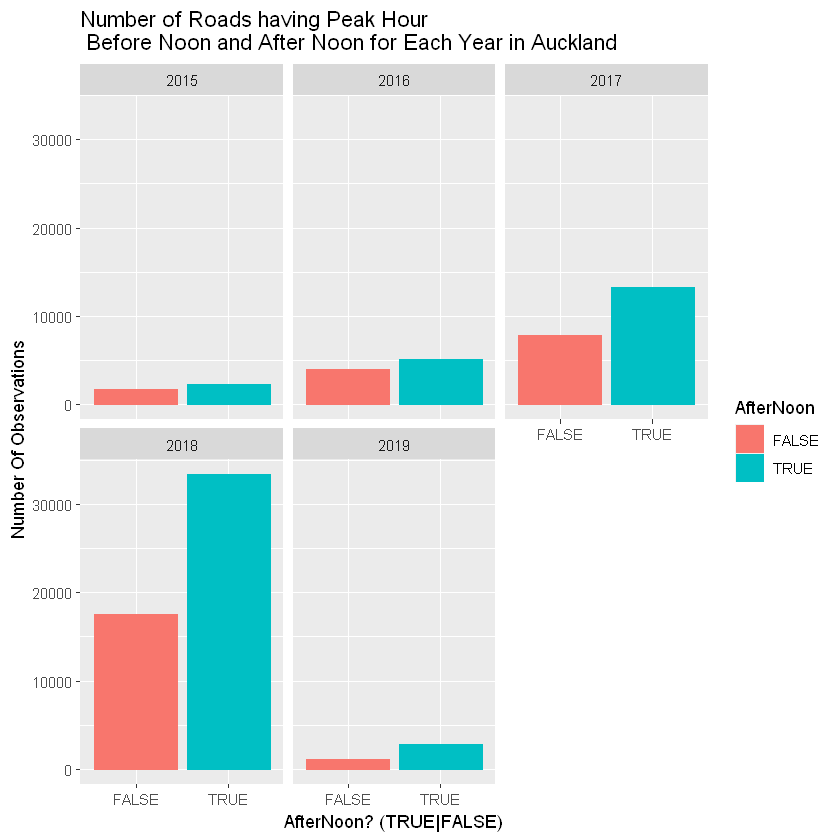

In [58]:
ggplot(After_Noon, aes(x=AfterNoon, y=n, color=AfterNoon)) + 
geom_col(aes(fill =  AfterNoon)) + 
facet_wrap(~ Count_Year) +

ggtitle("Number of Roads having Peak Hour \n Before Noon and After Noon for Each Year in Auckland") + 
xlab("AfterNoon? (TRUE|FALSE)") +
ylab("Number Of Observations")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



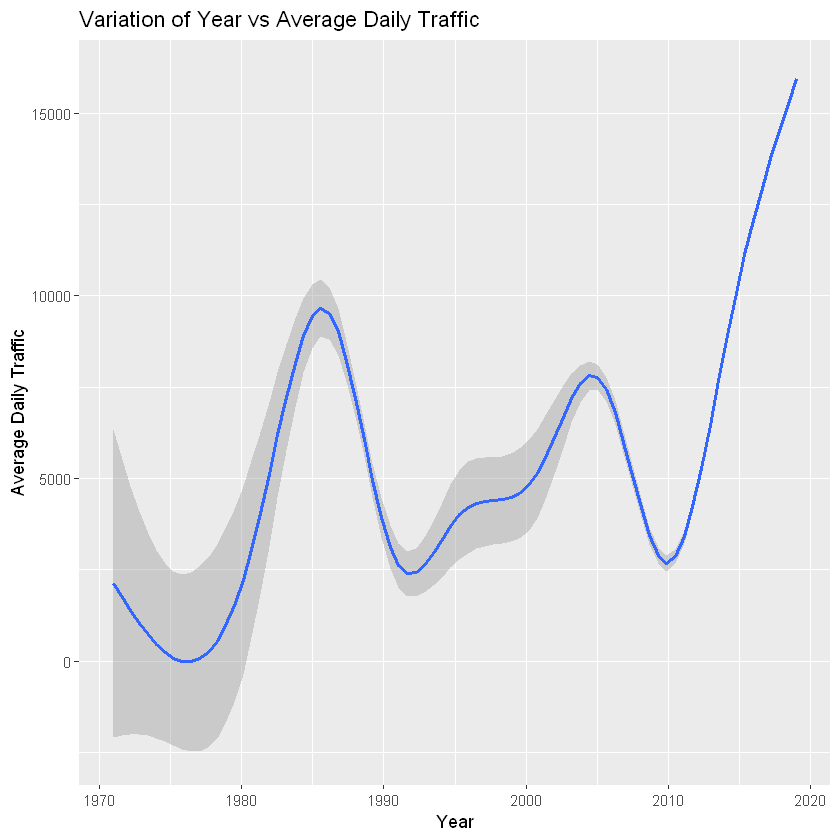

In [59]:
ggplot(Merged_to_Crash, aes(x=Count_Year, y=ADT)) + 
geom_smooth() + 

ggtitle("Variation of Year vs Average Daily Traffic") + 
xlab("Year") +
ylab("Average Daily Traffic")

Selecting by Perc_Light_CommVehicles

Selecting by Perc_Light_CommVehicles



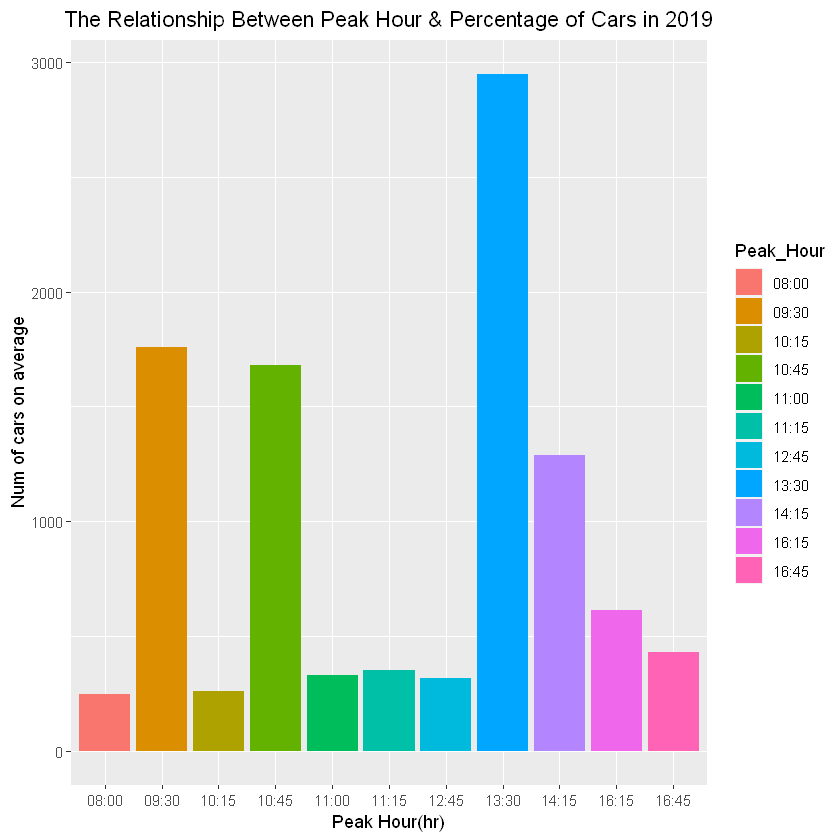

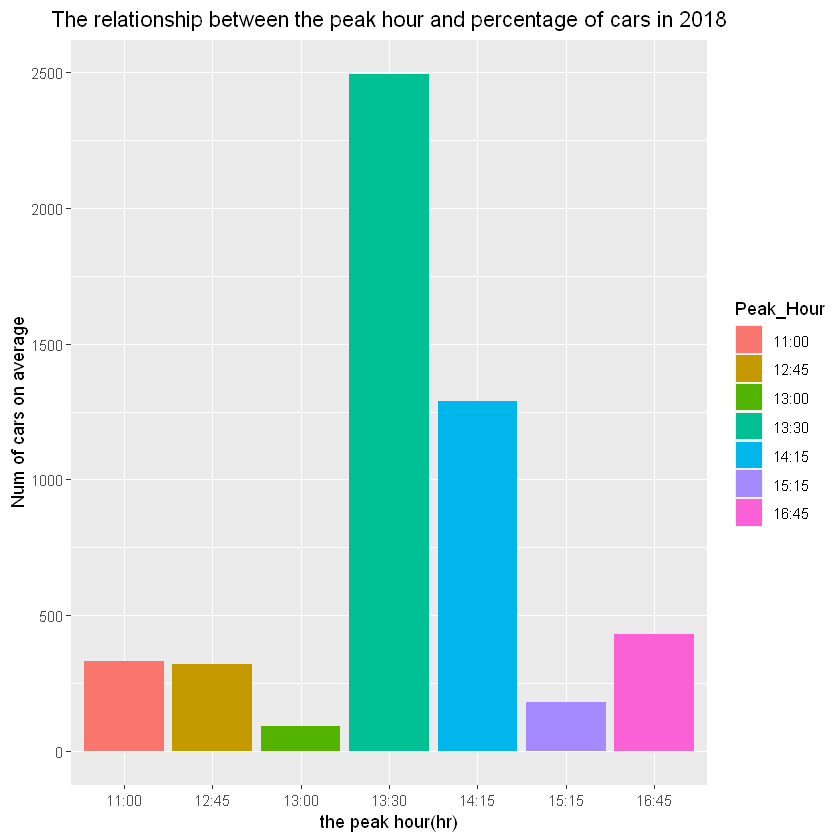

In [60]:
#Plotting The relationship between Peak hour and Percentage of cars in 2019
Merged_to_Crash %>%
  filter(Count_Year >= 2018) %>% # just check the year 2019
  arrange(Peak_Hour) %>% # arrange it in peak hour
  top_n(110) %>% # only for top 110 otherwise there will be too many
  ggplot(aes(x = Peak_Hour, y = Perc_Cars)) + # make the x-axis, y-axis 
  geom_bar(stat = "identity", aes(fill =  Peak_Hour)) +# create a bar chart
  #connect observations in order
  

  ggtitle("The Relationship Between Peak Hour & Percentage of Cars in 2019") + # create title
  theme(plot.title = element_text(hjust=0.5)) + # put title in the right middle
  xlab("Peak Hour(hr)") + # x-axis lable
  ylab("Num of cars on average") -> plot_graph_2019 # y-axis lable 

#Plotting The relationship between Peak hour and Percentage of cars in 2018
Merged_to_Crash %>%
  filter(Count_Year >= 2015) %>% # just check the year 2019
  arrange(Peak_Hour) %>% # arrange it in peak hour
  top_n(25) %>% # only for top 110 otherwise there will be too man
  ggplot(aes(x = Peak_Hour, y = Perc_Cars)) + # make the x-axis, y-axis
  geom_bar(stat = "identity", aes(fill =  Peak_Hour)) +# create a bar chart
  #connect observations in order

  ggtitle("The relationship between the peak hour and percentage of cars in 2018") + # create title
  theme(plot.title = element_text(hjust=0.5)) + # put title in the right middle
  xlab("the peak hour(hr)") + # x-axis lable
  ylab("Num of cars on average") -> plot_graph_2018 # y-axis lable 

plot_graph_2019
plot_graph_2018

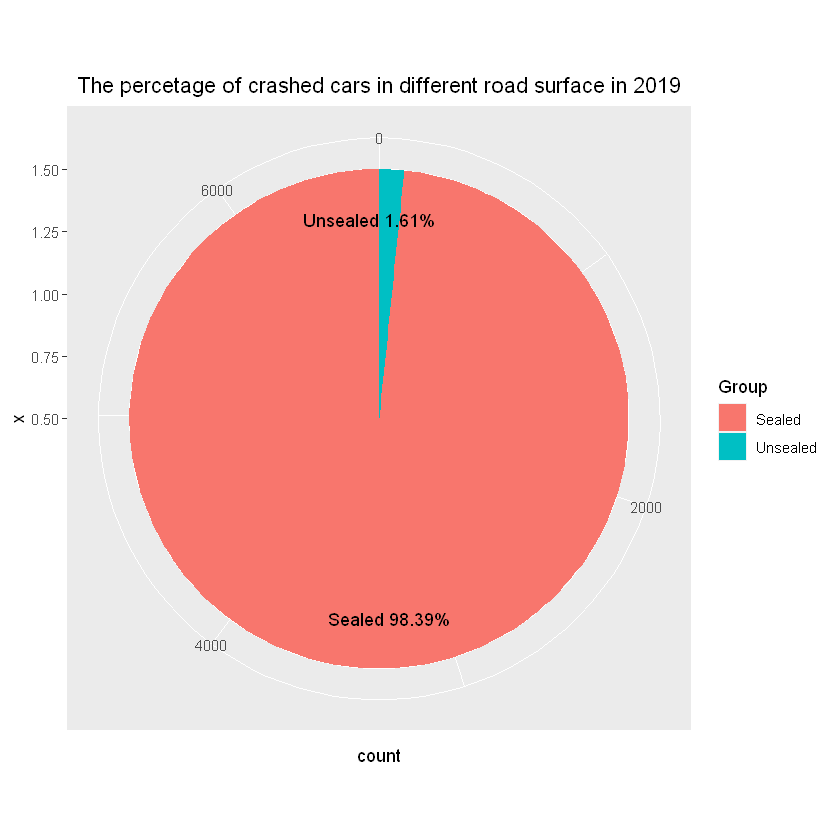

In [61]:
way22016 <- Merged_to_Traffic %>% filter(Count_Year == 2016) %>% filter(Road_Surface == "Sealed") %>% nrow() 
wayoff2016 <- Merged_to_Traffic %>% filter(Count_Year == 2016) %>% filter(Road_Surface == "Unsealed") %>% nrow() 


df <- data.frame(value = c(way22016, wayoff2016),
                 Group = c("Sealed", "Unsealed")) %>%
   # factor levels need to be the opposite order of the cumulative sum of the values
   mutate(cumulative = cumsum(value),
          midpoint = cumulative - value / 2,
          label = paste0(Group, " ", round(value / sum(value) * 100, 2), "%"))
          # make the value to percentage and rounded to 2 decimal places

df %>% ggplot(aes(x = 1, weight = value, fill = Group)) +
   geom_bar(width = 1, position = "stack") + # plot a bar chat
   coord_polar(theta = "y") + ## t-axis is the coordinate
   ggtitle("The percetage of crashed cars in different road surface in 2019") +
   theme(plot.title = element_text(hjust=0.5)) + # put title in the right middle
   geom_text(aes(x = 1.3, y = midpoint, label = label))## add percentage title and their position

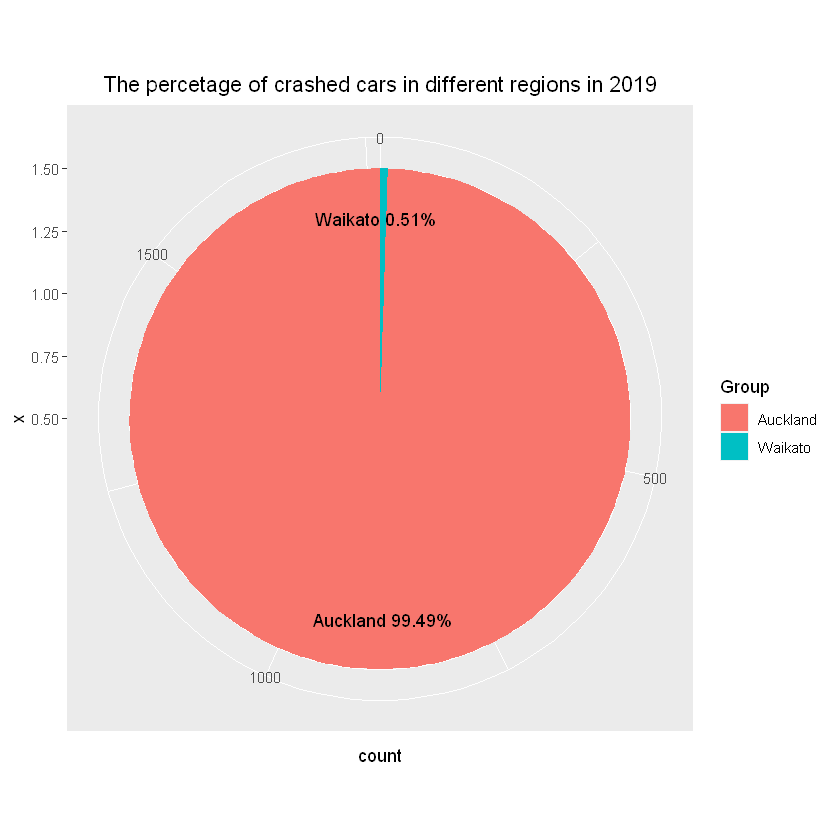

In [62]:
Auckland_2019 <- Merged_to_Traffic %>% filter(Count_Year == 2019) %>% filter(Region == "Auckland Region") %>% nrow() 
Waikato_2019 <- Merged_to_Traffic %>% filter(Count_Year == 2019) %>% filter( Region == "Waikato Region") %>% nrow() 


df <- data.frame(value = c(Auckland_2019, Waikato_2019),
                 Group = c("Auckland", "Waikato")) %>%
   # factor levels need to be the opposite order of the cumulative sum of the values
   mutate(cumulative = cumsum(value),
          midpoint = cumulative - value / 2,
          label = paste0(Group, " ", round(value / sum(value) * 100, 2), "%"))
          # make the value to percentage and rounded to 2 decimal places

df %>% ggplot(aes(x = 1, weight = value, fill = Group)) +
   geom_bar(width = 1, position = "stack") + # plot a bar chat
   coord_polar(theta = "y") + ## t-axis is the coordinate
   ggtitle("The percetage of crashed cars in different regions in 2019") +
   theme(plot.title = element_text(hjust=0.5)) + # put title in the right middle
   geom_text(aes(x = 1.3, y = midpoint, label = label))## add percentage title and their position

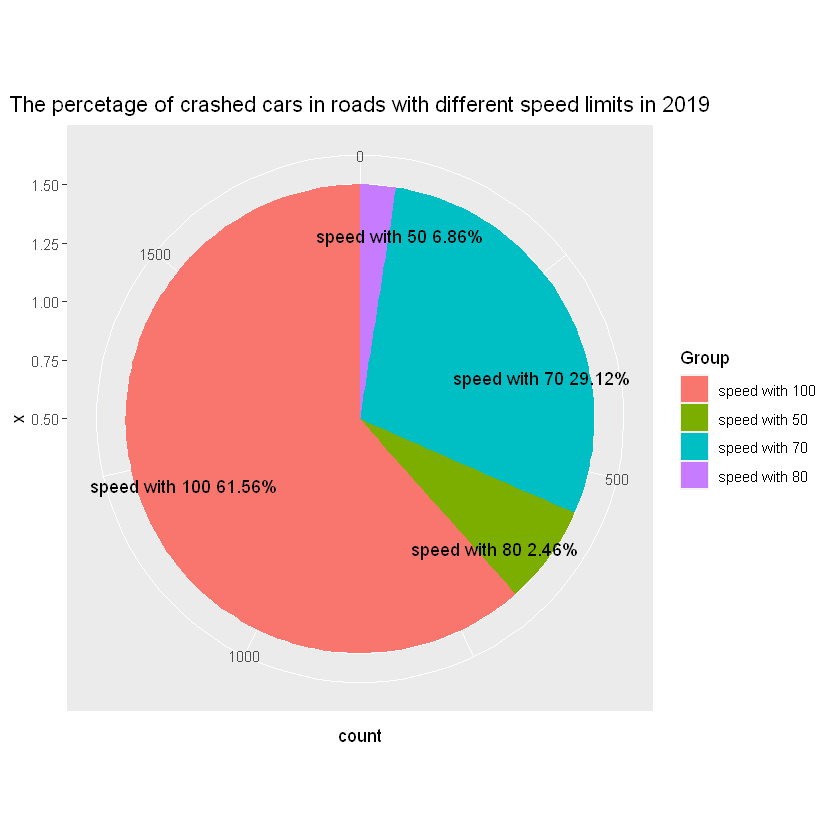

In [63]:
speed100_2019 <- Merged_to_Traffic %>% filter(Count_Year == 2019) %>% filter(Speed_Limit == 100) %>% nrow() 
speed80_2019 <- Merged_to_Traffic %>% filter(Count_Year == 2019) %>% filter(Speed_Limit == 80) %>% nrow() 
speed70_2019 <- Merged_to_Traffic %>% filter(Count_Year == 2019) %>% filter(Speed_Limit == 70) %>% nrow()
speed50_2019 <- Merged_to_Traffic %>% filter(Count_Year == 2019) %>% filter(Speed_Limit == 50) %>% nrow()

df <- data.frame(value = c(speed80_2019, speed100_2019, speed70_2019, speed50_2019),
                 Group = c("speed with 50", "speed with 70", "speed with 80", "speed with 100")) %>%
   # factor levels need to be the opposite order of the cumulative sum of the values
   mutate(cumulative = cumsum(value),
          midpoint = cumulative - value / 2,
          label = paste0(Group, " ", round(value / sum(value) * 100, 2), "%"))
          # make the value to percentage and rounded to 2 decimal places

df %>% ggplot(aes(x = 1, weight = value, fill = Group)) +
   geom_bar(width = 1, position = "stack") + # plot a bar chat
   coord_polar(theta = "y") + ## t-axis is the coordinate
   ggtitle("The percetage of crashed cars in roads with different speed limits in 2019") +
   theme(plot.title = element_text(hjust=0.5)) + # put title in the right middle
   geom_text(aes(x = 1.3, y = midpoint, label = label))## add percentage title and their position

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



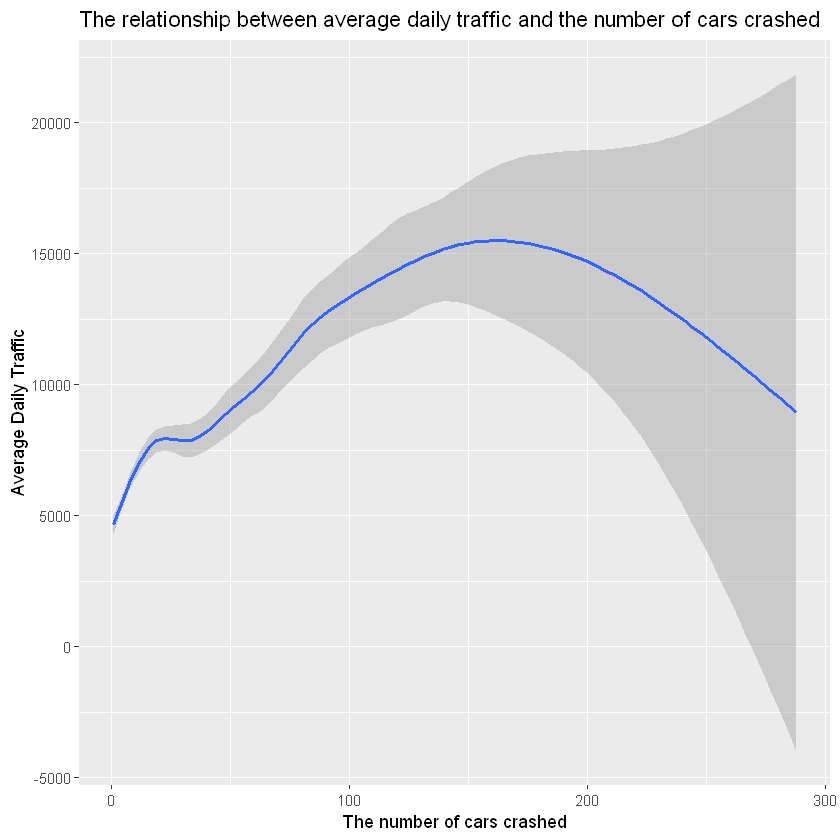

In [64]:
Final_Dataset %>% 
  ggplot(aes(x=Number_of_Crashes, y=ADT)) + 
  geom_smooth() + 
  ggtitle("The relationship between average daily traffic and the number of cars crashed") + 
  xlab("The number of cars crashed") +
  ylab("Average Daily Traffic")

In [65]:
#Thank You!